# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Bayesian regression

This notebook presents a simple example of Bayesian regression using sythetic data

### Data

Suppose there is a linear relationship between `x` and `y` with slope 2 and intercept 1, but the measurements of `y` are noisy; specifically, the noise is Gaussian with mean 0 and `sigma = 0.3`. 

In [389]:
slope = 2
inter = 1
sigma = 0.5

In [390]:
xs = np.linspace(0, 1, 12)

In [391]:
ys = inter + slope * xs + np.random.normal(0, sigma, len(xs))

In [392]:
slope, inter = 2, 1
resid = slope * xs + inter - ys
resid

array([ 0.34348102, -0.63839186, -0.25776954,  0.32169205,  0.21687371,
        0.49397838,  0.00188754, -0.01877609,  0.27022168,  0.1719328 ,
       -0.1537705 , -0.54141238])

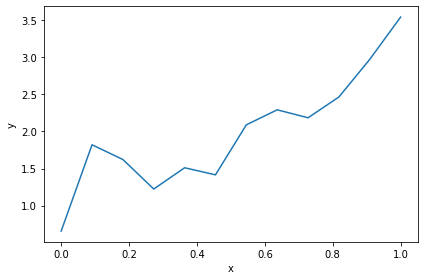

In [393]:
plt.plot(xs, ys)
decorate(xlabel='x', ylabel='y')

### Grid algorithm

We can solve the problem first using a grid algorithm, with uniform priors for slope, intercept, and sigma.

As an exercise, fill in this likelihood function, then test it using the code below.

Your results will depend on the random data you generated, but in general you should find that the posterior marginal distributions peak near the actual parameters.

In [394]:
slopes = np.linspace(0, 4, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'slope'

In [395]:
inters = np.linspace(0, 3, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'intercept'

In [396]:
sigmas = np.linspace(0.01, 2.01, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'sigma'

In [397]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.
    
    First Series across the columns;
    second goes goes down the rows.
    
    s1: Series
    s2: Series
    
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [398]:
joint = make_joint(prior_slope, prior_inter)
joint.shape

(41, 51)

In [399]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

slope  intercept
0.0    0.000        1
       0.075        1
       0.150        1
       0.225        1
       0.300        1
dtype: int64

In [400]:
prior3 = make_joint(prior_sigma, joint_pmf)
prior3.shape

(2091, 31)

In [401]:
slope, inter = 2, 1
resids = (slope * xs + inter) - ys
resids

array([ 0.34348102, -0.63839186, -0.25776954,  0.32169205,  0.21687371,
        0.49397838,  0.00188754, -0.01877609,  0.27022168,  0.1719328 ,
       -0.1537705 , -0.54141238])

In [402]:
sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resids)
sigma_mesh.shape

(12, 31)

In [403]:
from scipy.stats import norm

densities = norm(0, sigma_mesh).pdf(resid_mesh)
densities.shape

(12, 31)

In [404]:
from scipy.stats import norm

densities = norm.pdf(resid_mesh, 0, sigma_mesh)
densities.shape

(12, 31)

In [405]:
like = densities.prod(axis=0)
like.shape
like

array([0.00000000e+00, 4.41421374e-44, 2.96212169e-10, 2.63108747e-04,
       8.28295452e-03, 1.55557220e-02, 1.09901937e-02, 5.35076907e-03,
       2.26862376e-03, 9.25414039e-04, 3.79779078e-04, 1.59986327e-04,
       6.97735849e-05, 3.15929822e-05, 1.48523706e-05, 7.23978748e-06,
       3.65198683e-06, 1.90218845e-06, 1.02078585e-06, 5.63173276e-07,
       3.18787097e-07, 1.84799152e-07, 1.09520374e-07, 6.62528555e-08,
       4.08515027e-08, 2.56412689e-08, 1.63637834e-08, 1.06064725e-08,
       6.97545798e-09, 4.65047675e-09, 3.14041472e-09])

In [406]:
posterior_sigma = prior_sigma * like
posterior_sigma.normalize()

0.04430793606955434

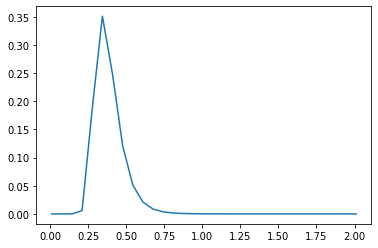

In [407]:
posterior_sigma.plot()

In [408]:
likelihood = prior3.copy()

for (slope, inter), sigmas in prior3.iterrows():
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [409]:
from utils import normalize

posterior3 = prior3 * likelihood
normalize(posterior3)
posterior3.shape

(2091, 31)

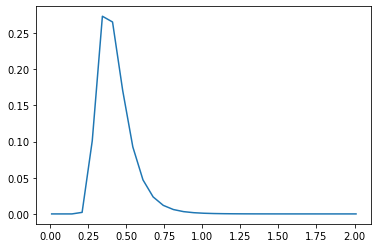

In [410]:
from utils import marginal

posterior_sigma = marginal(posterior3, 0)
posterior_sigma.plot()

In [411]:
posterior_pmf = marginal(posterior3, 1)
posterior_pmf.shape

(2091,)

In [412]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [413]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

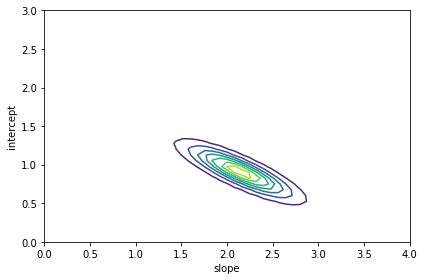

In [414]:
plot_contour(posterior_joint)

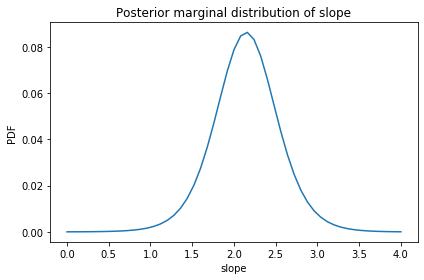

In [415]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [416]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(2.1457628645122475, array([1.52, 2.8 ]))

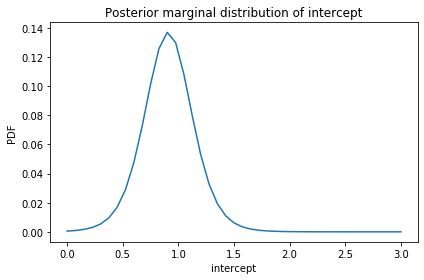

In [417]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [418]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(0.9098463288021751, array([0.525, 1.275]))